In [1]:
from google.colab import drive
drive.mount('/content/drive')
%cd drive/MyDrive/ML/innovation_lab

Mounted at /content/drive
/content/drive/MyDrive/ML/innovation_lab


In [2]:
#Function to give number of hedge words and non-hedge words

import re
import nltk
nltk.download('wordnet')
nltk.download('stopwords')

hedge_list=['perhaps', 'maybe', 'admittedly', 'admittingly','might', 'possibly', 'likely', 'probably', 'predominantly', 'presumably', 'seems', 'seemingly', 'appears', 'may', 'think', 'suggests', 'sometimes', 'often', 'around', 'roughly', 'fairly', 'usually', 'guess']

def hedge(sent):
  hword=0
  sent=sent.lower()
  sent=re.sub("[^A-Za-z0-9\s]","",sent)
  # print(sent)
  sent_split=sent.split()
  slen=len(sent_split)
  for word in sent_split:
    if word in hedge_list:
      hword+=1
  nhword=slen-hword
  return (slen,hword,nhword)

sent='it might! rain today, and we May possibly! get drenched, so carry your umbrella.'
print(sent,hedge(sent),sep='\n')

[nltk_data] Downloading package wordnet to /root/nltk_data...


it might! rain today, and we May possibly! get drenched, so carry your umbrella.
(14, 3, 11)


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [3]:
"""
DATA EXTRACTION FROM REVIEW TEXT
"""

import os
import re
import pandas as pd
import numpy as np
from typing import Sized
import json
import matplotlib.pyplot as plt
import pdb




#LISTS
src_file_fin=[]
decision_list_fin = []
para_list_fin = []
sent_count_fin = []
word_count_fin = []
word_freq_fin = []
char_freq_fin = []
vocab_len_fin = []
hedge_fin = []
nhedge_fin = []
hedge_ratio_fin = []
section_count_fin = []
aspect_count_fin = []
section_list_fin = []
aspect_list_fin = []




#PAPER META DECISION
deci_df = pd.read_csv('/content/drive/MyDrive/ML/innovation_lab/golden_info/reviews_csv.csv')
# print(deci_df.head())
deci_df.drop_duplicates(subset ="paper_id", keep = 'first', inplace = True)
deci_df.sort_values("paper_id", inplace = True)
deci_df.reset_index(inplace = True)
r_deci_df = deci_df[['paper_id','decision_meta']].copy()

deci_dic={}
for i in range(len(r_deci_df['paper_id'])):
  if (r_deci_df['decision_meta'][i].lower()).find('accept')!=-1:
    deci_dic[r_deci_df['paper_id'][i]]='accept'
  else:
    deci_dic[r_deci_df['paper_id'][i]]='reject'





#TEXT FILE ITERATION
src = '/content/drive/MyDrive/ML/innovation_lab/Annotated_Review_18' #PATH to directory containing all review txt files
src_file = sorted(os.listdir(src))
print(len(src_file))

s_count_dic = {'ABS':None, 'INT':None, 'RWK':None, 'PDI':None, 'DAT':None, 'MET':None, 'EXP':None, 'RES':None, 'TNF':None, 'ANA':None, 'FWK':None, 'OAL':None, 'BIB':None, 'EXT':None}
a_count_dic = {'APR':None, 'NOV':None, 'IMP':None, 'CMP':None, 'PNF':None, 'REC':None, 'EMP':None, 'SUB':None, 'CLA':None}


for txt_file in src_file:
  # print('\n',txt_file)
  name=txt_file.split('_annotated')[0]

  file1 = open(os.path.join(src,txt_file),"r")
  s=file1.readlines()
  # print(s,len(s))

  # 14 sections, 9 aspects
  section_dic = {'ABS':None, 'INT':None, 'RWK':None, 'PDI':None, 'DAT':None, 'MET':None, 'EXP':None, 'RES':None, 'TNF':None, 'ANA':None, 'FWK':None, 'OAL':None, 'BIB':None, 'EXT':None}
  aspect_dic = {'APR':None, 'NOV':None, 'IMP':None, 'CMP':None, 'PNF':None, 'REC':None, 'EMP':None, 'SUB':None, 'CLA':None}

  A=s[0].split(']]')
  B=[]
  for sen in A:
    sen=sen+']]'
    sen=sen.replace('"','')
    sen=sen.replace('\\n',' ')
    sen=sen.strip()
    sen=sen.replace('\\u201c','"')
    sen=sen.replace('\\u201d','"')
    sen=sen.replace('\\u2018','\'')
    sen=sen.replace('\\u2019','\'')
    sen=sen.replace('\\u2026','...')
    sen=sen.replace('\\','')
    sen=sen.replace('=',' ')
    B.append(sen)
  B.pop()

  if len(B)==0:
    continue

  src_file_fin.append(name)

  name=(name.split('-',1)[-1])[:-3]
  if name not in deci_dic.keys():
    decision_list_fin.append(np.nan)
  elif deci_dic[name]=='accept':
    decision_list_fin.append('Accept')
  elif deci_dic[name]=='reject':
    decision_list_fin.append('Reject')
  else:
    print(txt_file)
    print("ERROR: unexpected error in decision assignment")
    break

  sec_list=[]
  asp_list=[]
  para_list=[]
  wrd_len_list=[]
  for sen in B:
    # print(sen)
    sentence = sen.split("[[")[0]
    para_list.append(sentence)
    labels = "[["+sen.split("[[")[-1]
    labels=labels[1:-1]
    # print(type(labels), labels)
    sections=labels.split('],')[0].strip()+']'
    # print(type(sections),sections)
    aspects=labels.split('],')[1].strip()+']'

    section_list=sections.split(',')
    # print(type(section_list),section_list)
    if len(section_list)>1:
      section_list[0]=section_list[0][1:]
      section_list[-1]=section_list[-1][:-1]
    else:
      section_list[0]=section_list[0][1:-1]
    # print('1',section_list)
    aspect_list=aspects.split(',')
    if len(aspect_list)>1:
      aspect_list[0]=aspect_list[0][1:]
      aspect_list[-1]=aspect_list[-1][:-1]
    else:
      aspect_list[0]=aspect_list[0][1:-1]

    for i in range(len(section_list)):
      section_list[i] = section_list[i].split('-')
    # print('2',section_list,sec_list)
    for i in range(len(aspect_list)):
      aspect_list[i] = aspect_list[i].split('-')

    for i in section_list:
      i[0]=(i[0].upper()).strip()
      if i[0] in section_dic.keys() and i[0] not in sec_list:
        sec_list.append(i[0])
    # print('3',section_list,sec_list)
    for i in aspect_list:
      i[0]=(i[0].upper()).strip()
      if i[0] in aspect_dic.keys() and i[0] not in asp_list:
        asp_list.append(i[0])

    for item in section_list:
      item[0]=item[0].upper()
      if item[0]=='NULL':
        break
      # print(item, section_dic[item[0]], type(section_dic[item[0]]))
      if item[0] not in section_dic.keys():
        continue
      if not section_dic[item[0]]:
        section_dic[item[0]]=[sentence]
      else:
        section_dic[item[0]].append(sentence)
    for item in aspect_list:
      item[0]=item[0].upper()
      if item[0]=='NULL':
        break
      # print(item, len(aspect_dic[item[0]]))
      if item[0] not in aspect_dic.keys():
        continue
      if not aspect_dic[item[0]]:
        aspect_dic[item[0]]=[sentence]
      else:
        aspect_dic[item[0]].append(sentence)


  section_count_fin.append(len(sec_list))
  aspect_count_fin.append(len(asp_list))

  para=(' ').join(para_list)
  para_list_fin.append(para)
  sent_count_fin.append(len(B))
  wrd_count,hcount,nhcount=hedge(para)[0],hedge(para)[1],hedge(para)[2]
  word_count_fin.append(wrd_count)
  word_freq_fin.append(wrd_count/len(para.split('. ')))
  para=para.lower()
  para=re.sub("\."," ",para)
  para=re.sub("[^A-Za-z\s]","",para)
  para=re.sub("\s\S{1}\s"," ",para)
  wrd_lst=para.split()
  for i in wrd_lst:
    wrd_len_list.append(len(i.strip()))
  if len(wrd_len_list)>0:
    char_freq_fin.append(sum(wrd_len_list)/len(wrd_len_list))
  else:
    char_freq_fin.append(0)
  vocab_len_fin.append(len(set(wrd_lst)))
  hedge_fin.append(hcount)
  nhedge_fin.append(nhcount)
  if nhcount>0:
    hedge_ratio_fin.append(hcount/nhcount)
  else:
    hedge_ratio_fin.append(1)

  sec_s=[]
  asp_s=[]
  for item in section_dic:
    if section_dic[item]:
      sec_s.append(len(section_dic[item]))
    else:
      sec_s.append(0)
  # print("\n")
  for item in aspect_dic:
    if aspect_dic[item]:
      asp_s.append(len(aspect_dic[item]))
    else:
      asp_s.append(0)

  s_lst={}
  s_keys=[x for x in section_dic.keys()]
  for i in range(len(sec_s)):
    s_lst[s_keys[i]]=sec_s[i]
    # print(s_count_dic[s_keys[i]],sec_s[i])
    if not s_count_dic[s_keys[i]]:
      s_count_dic[s_keys[i]]=sec_s[i]
    else:
      s_count_dic[s_keys[i]]=s_count_dic[s_keys[i]]+sec_s[i]
  a_lst={}
  a_keys=[x for x in aspect_dic.keys()]
  for i in range(len(asp_s)):
    a_lst[a_keys[i]]=asp_s[i]
    if not a_count_dic[a_keys[i]]:
      a_count_dic[a_keys[i]]=asp_s[i]
    else:
      a_count_dic[a_keys[i]]=a_count_dic[a_keys[i]]+asp_s[i]
  section_list_fin.append(s_lst)
  aspect_list_fin.append(a_lst)


print('{} {} {} {} {} {} {} {} {} {} {} {} {} {} {}\n'
.format(len(src_file_fin), len(decision_list_fin), len(para_list_fin), len(sent_count_fin), len(word_count_fin), len(word_freq_fin), len(char_freq_fin), len(vocab_len_fin),
        len(hedge_fin), len(nhedge_fin), len(hedge_ratio_fin), len(section_count_fin), len(aspect_count_fin), len(section_list_fin), len(aspect_list_fin)))

review_dic = {'review_id':src_file_fin, 'meta_decision':decision_list_fin, 'review':para_list_fin, 'sentence count':sent_count_fin, 'word count':word_count_fin, 'avg. sentence length':word_freq_fin, 'avg. word length':char_freq_fin,
              'vocab length':vocab_len_fin, 'hedge words':hedge_fin, 'non-hedge words':nhedge_fin, 'hedge ratio':hedge_ratio_fin, 'sections covered (out of 14)':section_count_fin, 'aspects covered (out of 9)':aspect_count_fin, 
              'section distribution':section_list_fin, 'aspect distribution':aspect_list_fin}
review_df=pd.DataFrame(review_dic)
review_df

1323
1322 1322 1322 1322 1322 1322 1322 1322 1322 1322 1322 1322 1322 1322 1322



,review_id,meta_decision,review,sentence count,word count,avg. sentence length,avg. word length,vocab length,hedge words,non-hedge words,hedge ratio,sections covered (out of 14),aspects covered (out of 9),section distribution,aspect distribution
0,ICLR2018-B11bwYgfM-R1,NaN,The idea of using cross-task transfer performa...,12,242,20.166667,5.223176,121,2,240,0.008333,4,2,"{'ABS': 0, 'INT': 0, 'RWK': 2, 'PDI': 1, 'DAT'...","{'APR': 0, 'NOV': 3, 'IMP': 0, 'CMP': 0, 'PNF'..."
1,ICLR2018-B11bwYgfM-R2,NaN,This paper proposes a method for multitask and...,19,402,25.125000,5.311653,158,2,400,0.005000,5,2,"{'ABS': 0, 'INT': 0, 'RWK': 0, 'PDI': 1, 'DAT'...","{'APR': 0, 'NOV': 0, 'IMP': 0, 'CMP': 0, 'PNF'..."
2,ICLR2018-B11bwYgfM-R3,NaN,The authors propose techniques for multitask a...,35,763,19.564103,4.860955,278,11,752,0.014628,8,4,"{'ABS': 0, 'INT': 1, 'RWK': 3, 'PDI': 5, 'DAT'...","{'APR': 0, 'NOV': 1, 'IMP': 0, 'CMP': 4, 'PNF'..."
3,ICLR2018-B12Js_yRb-R1,Accept,Summary: - This paper proposes a hand-designe...,30,447,14.900000,5.240196,210,1,446,0.002242,11,7,"{'ABS': 0, 'INT': 2, 'RWK': 10, 'PDI': 3, 'DAT...","{'APR': 0, 'NOV': 0, 'IMP': 1, 'CMP': 5, 'PNF'..."
4,ICLR2018-B12Js_yRb-R2,Accept,Summary - This paper mainly focuses on a coun...,12,243,20.250000,5.757447,125,0,243,0.000000,8,3,"{'ABS': 0, 'INT': 2, 'RWK': 1, 'PDI': 3, 'DAT'...","{'APR': 0, 'NOV': 0, 'IMP': 0, 'CMP': 1, 'PNF'..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1317,ICLR2018-SysEexbRb-R2,Accept,This paper studies the critical points of shal...,23,456,20.727273,5.265700,194,3,453,0.006623,10,4,"{'ABS': 2, 'INT': 3, 'RWK': 1, 'PDI': 1, 'DAT'...","{'APR': 1, 'NOV': 0, 'IMP': 0, 'CMP': 1, 'PNF'..."
1318,ICLR2018-SysEexbRb-R3,Accept,This paper mainly focuses on the square loss f...,16,323,14.681818,5.738562,137,1,322,0.003106,8,7,"{'ABS': 0, 'INT': 1, 'RWK': 3, 'PDI': 0, 'DAT'...","{'APR': 0, 'NOV': 1, 'IMP': 2, 'CMP': 4, 'PNF'..."
1319,ICLR2018-Syt0r4bRZ-R1,Reject,Summary: the paper proposes a tree2tree archit...,20,323,14.681818,5.124590,167,2,321,0.006231,9,5,"{'ABS': 0, 'INT': 1, 'RWK': 2, 'PDI': 0, 'DAT'...","{'APR': 0, 'NOV': 1, 'IMP': 0, 'CMP': 2, 'PNF'..."
1320,ICLR2018-Syt0r4bRZ-R2,Reject,This paper proposes a tree-to-tree model aimin...,19,281,15.611111,4.949458,139,4,277,0.014440,9,6,"{'ABS': 0, 'INT': 1, 'RWK': 4, 'PDI': 1, 'DAT'...","{'APR': 1, 'NOV': 1, 'IMP': 0, 'CMP': 3, 'PNF'..."


section count: 
{'ABS': 68, 'INT': 1149, 'RWK': 3624, 'PDI': 2670, 'DAT': 1625, 'MET': 11265, 'EXP': 3881, 'RES': 2508, 'TNF': 1049, 'ANA': 1113, 'FWK': 186, 'OAL': 2045, 'BIB': 558, 'EXT': 420} 

aspect count: 
{'APR': 165, 'NOV': 770, 'IMP': 820, 'CMP': 2000, 'PNF': 1051, 'REC': 338, 'EMP': 10617, 'SUB': 1821, 'CLA': 1385}


 ['ABS', 'INT', 'RWK', 'PDI', 'DAT', 'MET', 'EXP', 'RES', 'TNF', 'ANA', 'FWK', 'OAL', 'BIB', 'EXT'] 
 [68, 1149, 3624, 2670, 1625, 11265, 3881, 2508, 1049, 1113, 186, 2045, 558, 420]


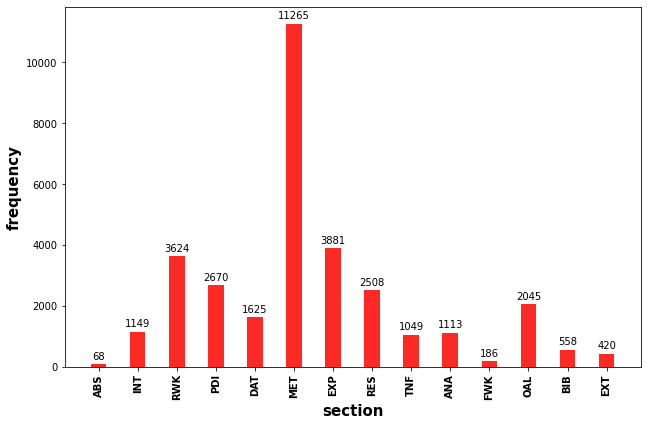



 ['APR', 'NOV', 'IMP', 'CMP', 'PNF', 'REC', 'EMP', 'SUB', 'CLA'] 
 [165, 770, 820, 2000, 1051, 338, 10617, 1821, 1385]


<Figure size 432x288 with 0 Axes>

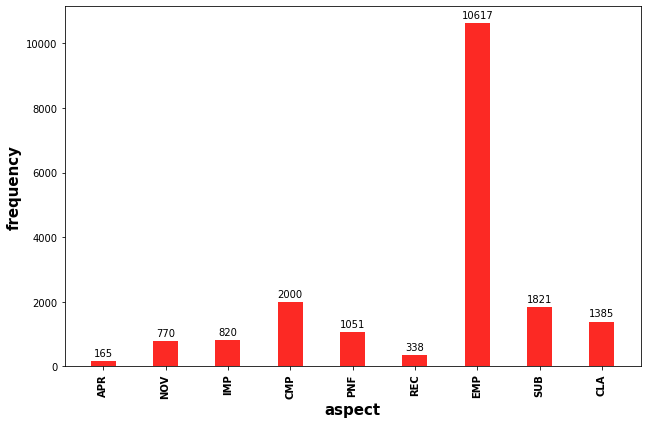

{'ABS': 68, 'INT': 1149, 'RWK': 3624, 'PDI': 2670, 'DAT': 1625, 'MET': 11265, 'EXP': 3881, 'RES': 2508, 'TNF': 1049, 'ANA': 1113, 'FWK': 186, 'OAL': 2045, 'BIB': 558, 'EXT': 420}
{'ABS': 2.114362115605858e-05, 'INT': 0.00035726501041634276, 'RWK': 0.0011268306333758278, 'PDI': 0.0008301980659805355, 'DAT': 0.0005052703585087528, 'MET': 0.0035026895929852926, 'EXP': 0.0012067410839215198, 'RES': 0.0007798264979322783, 'TNF': 0.00032617144989272723, 'ANA': 0.0003460713286278412, 'FWK': 5.783402257392494e-05, 'OAL': 0.0006358633127079382, 'BIB': 0.00017350206772177482, 'EXT': 0.00013059295419918534}


{'APR': 165, 'NOV': 770, 'IMP': 820, 'CMP': 2000, 'PNF': 1051, 'REC': 338, 'EMP': 10617, 'SUB': 1821, 'CLA': 1385}
{'APR': 8.699319871355512e-05, 'NOV': 0.00040596826066325724, 'IMP': 0.0004323298360310012, 'CMP': 0.001054463014709759, 'PNF': 0.0005541203142299784, 'REC': 0.0001782042494859493, 'EMP': 0.005597616913586756, 'SUB': 0.0009600885748932357, 'CLA': 0.0007302156376865082}


<Figure size 432x288 with 0 Axes>

In [4]:
"""
FINDING OVERALL OPINION AND ASPECT DISTRIBUTION
"""


#SECTION/ASPECT FREQUENCY DISTRIBUTION

print('section count: \n{} \n\naspect count: \n{}'.format(s_count_dic,a_count_dic))

layers = [s_count_dic, a_count_dic]
label = ['section', 'aspect']

i=0
for layer in layers:
  keys=[key for key in layer.keys()]
  data=[]
  for key in keys:
    data.append(layer[key])
  print('\n\n', keys, '\n', data)

  X = np.arange(len(keys))
  fig, ax = plt.subplots(figsize=(8,5))
  # fig = plt.figure()
  ax = fig.add_axes([0,0,1,1])
  ax.bar(X, data, color = '#fc2924', width = 0.40)
  ax.set_ylabel('frequency',size='15',fontweight='bold')
  ax.set_xlabel(label[i],size='15',fontweight='bold')
  ax.set_xticks(X)
  ax.set_xticklabels(keys,fontweight='bold')
  plt.xticks(rotation=90)
  pps = ax.bar(X, data, color = '#fc2924', width = 0.40)
  for p in pps:
    height = p.get_height()
    ax.annotate('{}'.format(height),
        xy=(p.get_x() + p.get_width() / 2, height),
        xytext=(0, 3), # 3 points vertical offset
        textcoords="offset points",
        ha='center', va='bottom')
  fig.savefig("/content/drive/MyDrive/ML/innovation_lab/golden_info/graphs/"+"dist_"+label[i], bbox_inches='tight',pad_inches=0.1)
  plt.show()
  plt.clf()
  i+=1


#SECTION/ASPECT WEIGHT
sum=0
for i in s_count_dic.keys():
  sum+=s_count_dic[i]
s_wt_dic={'ABS':None, 'INT':None, 'RWK':None, 'PDI':None, 'DAT':None, 'MET':None, 'EXP':None, 'RES':None, 'TNF':None, 'ANA':None, 'FWK':None, 'OAL':None, 'BIB':None, 'EXT':None}
for i in s_count_dic.keys():
  s_wt_dic[i]=s_count_dic[i]/(100*sum)

sum=0
for i in a_count_dic.keys():
  sum+=a_count_dic[i]
a_wt_dic={'APR':None, 'NOV':None, 'IMP':None, 'CMP':None, 'PNF':None, 'REC':None, 'EMP':None, 'SUB':None, 'CLA':None}
for i in a_count_dic.keys():
  a_wt_dic[i]=a_count_dic[i]/(100*sum)

wt_dic={'sec':s_wt_dic, 'asp':a_wt_dic}
with open("/content/drive/MyDrive/ML/innovation_lab/golden_info/weights.json", "w") as outfile:
    json.dump(wt_dic, outfile)

print(s_count_dic,s_wt_dic,'\n',a_count_dic,a_wt_dic,sep='\n')

In [5]:
"""
CRITERIA FORMULA:
criteria score = (no. of unique sections covered + sum(no. of sentences covering i'th section * section weight))/(total no. of sections)
+
CREATE CSV FILE
"""
#lists:
sec_score_fin = []
asp_score_fin = []
info_score_fin = []

# weights:
sec_wt=list(s_wt_dic.values())
asp_wt=list(a_wt_dic.values())
   
sec_dist_list=list(review_df['section distribution'])
asp_dist_list=list(review_df['aspect distribution'])

for count in range(review_df.shape[0]):
  sec_dist=list(sec_dist_list[count].values())[:]
  asp_dist=list(asp_dist_list[count].values())[:]
  sec_count=0
  asp_count=0
  for i in range(len(sec_dist)):
    if sec_dist[i]>0:
      sec_count+=1
      sec_dist[i]=(sec_dist[i]-1)*(sec_wt[i])
  for i in range(len(asp_dist)):
    if asp_dist[i]>0:
      asp_count+=1
      asp_dist[i]=(asp_dist[i]-1)*(asp_wt[i])

  s_len=0
  a_len=0
  for i in sec_dist:
    s_len+=i
  for i in asp_dist:
    a_len+=i

  section_score=((sec_count+s_len)/len(sec_dist))
  aspect_score=((asp_count+a_len)/len(asp_dist))
  if section_score>=1:
    section_score=1
  if aspect_score>=1:
    aspect_score=1
  hcount=list(review_df['hedge words'])[count]
  nhcount=list(review_df['non-hedge words'])[count]

  sec_score_fin.append(section_score)
  asp_score_fin.append(aspect_score)


scores_df=pd.DataFrame({'section score':sec_score_fin, 'aspect score':asp_score_fin})
review_temp_df=pd.concat([review_df,scores_df],axis=1)
review_temp_df.to_csv('/content/drive/MyDrive/ML/innovation_lab/golden_info/Review_Dataset_temp.csv',index=False)
review_temp_df

,review_id,meta_decision,review,sentence count,word count,avg. sentence length,avg. word length,vocab length,hedge words,non-hedge words,hedge ratio,sections covered (out of 14),aspects covered (out of 9),section distribution,aspect distribution,section score,aspect score
0,ICLR2018-B11bwYgfM-R1,NaN,The idea of using cross-task transfer performa...,12,242,20.166667,5.223176,121,2,240,0.008333,4,2,"{'ABS': 0, 'INT': 0, 'RWK': 2, 'PDI': 1, 'DAT'...","{'APR': 0, 'NOV': 3, 'IMP': 0, 'CMP': 0, 'PNF'...",0.286886,0.223556
1,ICLR2018-B11bwYgfM-R2,NaN,This paper proposes a method for multitask and...,19,402,25.125000,5.311653,158,2,400,0.005000,5,2,"{'ABS': 0, 'INT': 0, 'RWK': 0, 'PDI': 1, 'DAT'...","{'APR': 0, 'NOV': 0, 'IMP': 0, 'CMP': 0, 'PNF'...",0.361318,0.225954
2,ICLR2018-B11bwYgfM-R3,NaN,The authors propose techniques for multitask a...,35,763,19.564103,4.860955,278,11,752,0.014628,8,4,"{'ABS': 0, 'INT': 1, 'RWK': 3, 'PDI': 5, 'DAT'...","{'APR': 0, 'NOV': 1, 'IMP': 0, 'CMP': 4, 'PNF'...",0.577550,0.459101
3,ICLR2018-B12Js_yRb-R1,Accept,Summary: - This paper proposes a hand-designe...,30,447,14.900000,5.240196,210,1,446,0.002242,11,7,"{'ABS': 0, 'INT': 2, 'RWK': 10, 'PDI': 3, 'DAT...","{'APR': 0, 'NOV': 0, 'IMP': 1, 'CMP': 5, 'PNF'...",0.789854,0.785466
4,ICLR2018-B12Js_yRb-R2,Accept,Summary - This paper mainly focuses on a coun...,12,243,20.250000,5.757447,125,0,243,0.000000,8,3,"{'ABS': 0, 'INT': 2, 'RWK': 1, 'PDI': 3, 'DAT'...","{'APR': 0, 'NOV': 0, 'IMP': 0, 'CMP': 1, 'PNF'...",0.572586,0.336443
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1317,ICLR2018-SysEexbRb-R2,Accept,This paper studies the critical points of shal...,23,456,20.727273,5.265700,194,3,453,0.006623,10,4,"{'ABS': 2, 'INT': 3, 'RWK': 1, 'PDI': 1, 'DAT'...","{'APR': 1, 'NOV': 0, 'IMP': 0, 'CMP': 1, 'PNF'...",0.717566,0.453774
1318,ICLR2018-SysEexbRb-R3,Accept,This paper mainly focuses on the square loss f...,16,323,14.681818,5.738562,137,1,322,0.003106,8,7,"{'ABS': 0, 'INT': 1, 'RWK': 3, 'PDI': 0, 'DAT'...","{'APR': 0, 'NOV': 1, 'IMP': 2, 'CMP': 4, 'PNF'...",0.573514,0.780257
1319,ICLR2018-Syt0r4bRZ-R1,Reject,Summary: the paper proposes a tree2tree archit...,20,323,14.681818,5.124590,167,2,321,0.006231,9,5,"{'ABS': 0, 'INT': 1, 'RWK': 2, 'PDI': 0, 'DAT'...","{'APR': 0, 'NOV': 1, 'IMP': 0, 'CMP': 2, 'PNF'...",0.646486,0.561458
1320,ICLR2018-Syt0r4bRZ-R2,Reject,This paper proposes a tree-to-tree model aimin...,19,281,15.611111,4.949458,139,4,277,0.014440,9,6,"{'ABS': 0, 'INT': 1, 'RWK': 4, 'PDI': 1, 'DAT'...","{'APR': 1, 'NOV': 1, 'IMP': 0, 'CMP': 3, 'PNF'...",0.644999,0.671141
